# DAS Data Compression using Autoencoder

This notebook shows how to do lossy DAS data compression using neural networks (Autoencoder). The original code is from [TensorFlow Compression](https://github.com/tensorflow/compression).

## Paper and posts for understanding related theories

1. [End-to-end Optimized Image Compression](https://arxiv.org/abs/1611.01704)
2. [Image Compression Using Autoencoders in Keras](https://blog.paperspace.com/autoencoder-image-compression-keras/)
3. [AI-Based Image Compression: The State of the Art](https://towardsdatascience.com/ai-based-image-compression-the-state-of-the-art-fb5aa6042bfa)

## TODO

1. normalize
2. tool in scikit-image that will tile images
3. creat over lapping data

## Setup

Install Tensorflow Compression via `pip`.

In [1]:
%%bash
# Installs the latest version of TFC compatible with the installed TF version.

read MAJOR MINOR <<< "$(pip show tensorflow | perl -p -0777 -e 's/.*Version: (\d+)\.(\d+).*/\1 \2/sg')"
pip install "tensorflow-compression<$MAJOR.$(($MINOR+1))"


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.8/255.8 kB 4.5 MB/s eta 0:00:00


Import library dependencies.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import tensorflow_compression as tfc
import tensorflow_datasets as tfds

plt.rcParams.update({'font.size': 14})

## Define the trainer model.

Because the model resembles an autoencoder, and we need to perform a different set of functions during training and inference, the setup is a little different from, say, a classifier.

The training model consists of three parts:
- the **analysis** (or encoder) transform, converting from the image into a latent space,
- the **synthesis** (or decoder) transform, converting from the latent space back into image space, and
- a **prior** and entropy model, modeling the marginal probabilities of the latents.

First, define the transforms:

In [3]:
def make_analysis_transform(latent_dims):
  """Creates the analysis (encoder) transform."""
  return tf.keras.Sequential([
      tf.keras.layers.Conv2D(20, 5, use_bias=True, strides=2, padding="same", activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2D(50, 5, use_bias=True, strides=2, padding="same", activation="leaky_relu", name="conv_2"),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(500, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(latent_dims, use_bias=True, activation=None, name="fc_2"),
  ], name="analysis_transform")


def make_synthesis_transform(patch_size):
  """Creates the synthesis (decoder) transform."""
  if (patch_size // 4) * 4 != patch_size:
    raise ValueError('patch_size must be dividable ny 4!')

  return tf.keras.Sequential([
      tf.keras.layers.Dense(500, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(50 * (patch_size//4)**2, use_bias=True, activation="leaky_relu", name="fc_2"),
      tf.keras.layers.Reshape((patch_size//4, patch_size//4, 50)),
      tf.keras.layers.Conv2DTranspose(20, 5, use_bias=True, strides=2, padding="same", activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2DTranspose(1, 5, use_bias=True, strides=2, padding="same", activation="leaky_relu", name="conv_2"),
  ], name="synthesis_transform")

daThe trainer holds an instance of both transforms, as well as the parameters of the prior.

Its `call` method is set up to compute:
- **rate**, an estimate of the number of bits needed to represent the batch of digits, and
- **distortion**, the mean absolute difference between the pixels of the original data patch and their reconstructions.


In [4]:
class DASCompressionTrainer(tf.keras.Model):
  """Model that trains a compressor/decompressor for DAS data."""

  def __init__(self, latent_dims, patch_size):
    super().__init__()
    self.analysis_transform = make_analysis_transform(latent_dims)
    self.synthesis_transform = make_synthesis_transform(patch_size)
    self.prior_log_scales = tf.Variable(tf.zeros((latent_dims,)))

  @property
  def prior(self):
    return tfc.NoisyLogistic(loc=0., scale=tf.exp(self.prior_log_scales))

  def call(self, x, training):
    """Computes rate and distortion losses."""
    # Ensure inputs are floats in the range (0, 1).

    # Note: since x is devided by 255, we need mutiply the 
    # original data by 255 to keep consistency in data preparation
    x = tf.cast(x, self.compute_dtype) / 255.

    # Compute latent space representation y, perturb it and model its entropy,
    # then compute the reconstructed pixel-level representation x_hat.
    y = self.analysis_transform(x)
    entropy_model = tfc.ContinuousBatchedEntropyModel(self.prior, coding_rank=1, compression=False)
    y_tilde, rate = entropy_model(y, training=training)
    x_tilde = self.synthesis_transform(y_tilde)

    # Average number of bits per MNIST digit.
    rate = tf.reduce_mean(rate)

    # Mean absolute difference across pixels.
    distortion = tf.reduce_mean(abs(x - x_tilde))

    return dict(rate=rate, distortion=distortion)


Train the model.
We compile the trainer in a way that it optimizes the rate–distortion Lagrangian, that is, a sum of rate and distortion, where one of the terms is weighted by Lagrange parameter  𝜆 .

This loss function affects the different parts of the model differently:

The analysis transform is trained to produce a latent representation that achieves the desired trade-off between rate and distortion.
The synthesis transform is trained to minimize distortion, given the latent representation.
The parameters of the prior are trained to minimize the rate given the latent representation. This is identical to fitting the prior to the marginal distribution of latents in a maximum likelihood sense.

In [5]:
def pass_through_loss(_, x):
  # Since rate and distortion are unsupervised, the loss doesn't need a target.
  return x


def add_rd_targets(image, label):
  # Training is unsupervised, so labels aren't necessary here. However, we
  # need to add "dummy" targets for rate and distortion.
  return image, dict(rate=0., distortion=0.)


def train_das_model(training_dataset,    # training dataset
                    validation_dataset,  # validation dataset
                    lmbda=2000,          # weight for rate–distortion Lagrangian
                    latent_dims=50,      # layers in latent space
                    patch_size = 28,     # patch size of the image, must be dividable by 4
                    epochs=15,           # epoch
                    batch_size=128,      # batch size
                    learning_rate=1e-3,  # learning rate
                    validation_freq=1,   # validation freq
                    ):

  trainer = DASCompressionTrainer(latent_dims, patch_size)
  trainer.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
      # Just pass through rate and distortion as losses/metrics.
      loss=dict(rate=pass_through_loss, distortion=pass_through_loss),
      metrics=dict(rate=pass_through_loss, distortion=pass_through_loss),
      loss_weights=dict(rate=1., distortion=lmbda),)

  history = trainer.fit(training_dataset.map(add_rd_targets).batch(batch_size).prefetch(8),
      epochs=epochs,
      validation_data=validation_dataset.map(add_rd_targets).batch(batch_size).cache(),
      validation_freq=validation_freq,
      verbose=1,)

  return trainer, history

## Tools for preparing DAS data

In [6]:
def extract_image_patches(DAS_data, patch_size):
  ''' Divide the DAS data (channels by time samples) into small
      patches with the size of patch_size

        Parameters
        ----------
        DAS_data : numpy array (channels by time samples)
        patch_size : int, size of the patch
        
        Returns
        -------
        patches : list of patches
        factors : list of factors used in patch normalization
  '''

  height, width, = DAS_data.shape

  patches = []
  factors = []
  for y in range(0, height - patch_size + 1, patch_size):
    for x in range(0, width - patch_size + 1, patch_size):

      # extract the patch
      patch = DAS_data[y:y + patch_size, x:x + patch_size]
        
      # post-process the patch
      patch = patch.reshape(patch_size, patch_size, 1)
      patch.astype(np.float32)

      # normalize the patch by to the scale of 255 (consistent with the code)
      norm_factor = 1.0 / np.max(abs(patch)) * 255
      patch = patch * norm_factor
      patch[patch == np.nan] = 0.0

    
      # append
      factors.append(norm_factor)
      patches.append(patch)

  return patches, factors


def prepare_das_dataset(data_list, train_ratio = 0.8, shuffle = True):
  ''' Split the data into training and validation sets

        Parameters  
        ----------
        data_list : list
            list of data
        train_ratio : float
            ratio of training data
        shuffle: boolean
            shuffle or not
        
        Returns
        -------
        training_dataset : tf.data.Dataset
            training dataset
        validation_dataset : tf.data.Dataset
            validation dataset          
  '''
  
  # Shuffle the data randomly (we can also do this using TensorFlow feature)
  if shuffle == True:
    random.shuffle(data_list)

  # Calculate the split index based on the train_ratio
  split_index = int(len(data_list) * train_ratio)

  # Split the data into training and validation sets
  train_data = data_list[:split_index]
  validation_data = data_list[split_index:]
  
  # Convert the Python lists to TensorFlow tensors
  train_data = tf.convert_to_tensor(train_data, dtype=tf.float32)
  validation_data = tf.convert_to_tensor(validation_data, dtype=tf.float32)

  # Create TensorFlow datasets (the label is the same as the input)
  training_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_data))
  validation_dataset = tf.data.Dataset.from_tensor_slices((validation_data, validation_data))

  return training_dataset, validation_dataset


def reconstruct_image_from_patches(patches, factors, original_shape, patch_size):
    ''' Reconstruct the original image from patches.

        Parameters
        ----------
        patches : list of patches
        original_shape : tuple, shape of the original image (channels, time samples)
        patch_size : int, size of the patch
        factors : list of factors used in patch normalization

        Returns
        -------
        reconstructed_image : numpy array, the reconstructed image
    '''

    height, width = original_shape

    reconstructed_image = np.zeros(original_shape)

    patch_index = 0
    for y in range(0, height - patch_size + 1, patch_size):
        for x in range(0, width - patch_size + 1, patch_size):

            # get the patch
            patch = patches[patch_index]
            patch = np.reshape(patch, (patch_size, patch_size))

            # restore the normalization
            patch = patch / factors[patch_index]
            patch[patch==np.nan] = 0.0

            # put the patch back to where it belongs to
            reconstructed_image[y:y + patch_size, x:x + patch_size] = patch
            patch_index += 1

    return reconstructed_image


## Load the preprocessed DAS data from the Google Storate

In [7]:
# load my google drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [8]:
from google.cloud import storage
from io import BytesIO

## Approch 1: Load the data from the Google Storage (unfinished and not test, no access)
# client = storage.Client()
# bucket = client.get_bucket("smcity-cs230-das")
# data = []
# for lblob in lblob_pro:
#   blob = bucket.get_blob(lblob)
#   data.append(np.load(BytesIO(blob.download_as_string())))

## Approch 2: copy the data from the Google Storage (unfinished and not test, no access)
# for lblob in lblob_pro:
#    ! gsutil cp gs://{lblob} /content/.


## Approch 3: mannually download to my Macbook and upload here (works for me!!!)

## Approch 4: Mount the Google Drive
# I select several data from my Google Drive, eight DAS sections for training
# file_path = './drive/MyDrive/Training Dataset/'
# file_train = [file_path + 'smcity_sandhill_nc3100_ch3000-6100_nt3000_sf5_bp0.08-2_D2022-10-25_T10-07-56_p10min.npz', \
#              file_path + 'smcity_sandhill_nc3100_ch3000-6100_nt3000_sf5_bp0.08-2_D2022-10-25_T10-17-56_p10min.npz', \
#              file_path + 'smcity_sandhill_nc3100_ch3000-6100_nt3000_sf5_bp0.08-2_D2022-10-25_T10-27-56_p10min.npz', \
#              file_path + 'smcity_sandhill_nc3100_ch3000-6100_nt3000_sf5_bp0.08-2_D2022-10-25_T10-47-56_p10min.npz', \
#              file_path + 'smcity_rwc_nc4800_ch37500-42300_nt3000_sf5_bp0.08-2_D2022-10-25_T10-07-56_p10min.npz', \
#              file_path + 'smcity_rwc_nc4800_ch37500-42300_nt3000_sf5_bp0.08-2_D2022-10-25_T10-17-56_p10min.npz', \
#              file_path + 'smcity_rwc_nc4800_ch37500-42300_nt3000_sf5_bp0.08-2_D2022-10-25_T10-37-56_p10min.npz', \
#              file_path + 'smcity_rwc_nc4800_ch37500-42300_nt3000_sf5_bp0.08-2_D2022-10-25_T10-47-56_p10min.npz'
#              ]

# two DAS section for testing
# file_test = [file_path + 'smcity_sandhill_nc3100_ch3000-6100_nt3000_sf5_bp0.08-2_D2022-10-25_T10-37-56_p10min.npz', \
#              file_path + 'smcity_rwc_nc4800_ch37500-42300_nt3000_sf5_bp0.08-2_D2022-10-25_T10-27-56_p10min.npz'     
#             ]

file_path = './drive/MyDrive/Training Dataset/effective_dataset/'
file_train = [file_path + 'smcity_sandhill_nc3100_ch3000-6100_nt3000_sf5_bp0.08-2_D2022-10-25_T10-07-56_p10min.npz', \
              file_path + 'smcity_sandhill_nc3100_ch3000-6100_nt3000_sf5_bp0.08-2_D2022-10-26_T00-37-56_p10min.npz', \
              file_path + 'smcity_rwc_nc4800_ch37500-42300_nt3000_sf5_bp0.08-2_D2022-10-25_T10-07-56_p10min.npz'
             ]

file_test = [
              file_path + 'smcity_rwc_nc4800_ch37500-42300_nt3000_sf5_bp0.08-2_D2022-10-26_T00-37-56_p10min.npz'    
            ]



Data shape:  (3100, 3000)
Number of channels:  3100
Number of chans:  [3000 6100]
Number of time samples:  3000
Sampling frequency:  5
Bandpass:  [0.08 2.  ]
Date:  1666692476


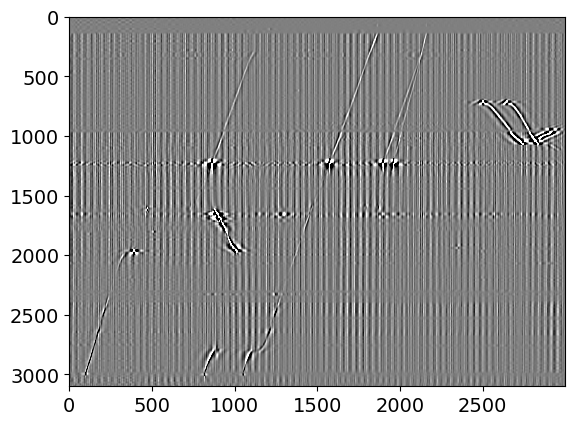

In [9]:
# Load DAS data
data = np.load(file_train[0])

# Retrieve the data and parameters
pdata = data['pdata']
nc = data['nc']
chans = data['chans']
nt = data['nt']
sf = data['sf']
bp = data['band']
date = data['date']

# Print info
print('Data shape: ', pdata.shape)
print('Number of channels: ', nc)
print('Number of chans: ', chans)
print('Number of time samples: ', nt)
print('Sampling frequency: ', sf)
print('Bandpass: ', bp)
print('Date: ', date)

# Plot
pclip = np.percentile(pdata, 99.)
plt.imshow(pdata, cmap='gray', aspect='auto', vmin=-pclip, vmax=pclip)

In [10]:
# Setup parameters
patch_size = 32
train_ratio = 0.8

# Extract image patches (we can join lists together from different data)
patches_all = []
factors_all = []

for i in file_train:
  print('Loading: %s'%(i))

  # Load the data
  pdata = np.load(i)['pdata']

  # Extract patches and normalzation factor
  patches, factors = extract_image_patches(pdata, patch_size)

  # union patches from different data
  patches_all += patches
  factors_all += factors

# Split the data into training and testing dataset
training_dataset, validation_dataset = prepare_das_dataset(patches_all, train_ratio = train_ratio, shuffle = True)

# Print info
print('\n')
print('Number of training data: ', len(training_dataset))
print('Number of validation data: ', len(validation_dataset))
print(training_dataset)
print(validation_dataset)

Loading: ./drive/MyDrive/Training Dataset/effective_dataset/smcity_sandhill_nc3100_ch3000-6100_nt3000_sf5_bp0.08-2_D2022-10-25_T10-07-56_p10min.npz
Loading: ./drive/MyDrive/Training Dataset/effective_dataset/smcity_sandhill_nc3100_ch3000-6100_nt3000_sf5_bp0.08-2_D2022-10-26_T00-37-56_p10min.npz
Loading: ./drive/MyDrive/Training Dataset/effective_dataset/smcity_rwc_nc4800_ch37500-42300_nt3000_sf5_bp0.08-2_D2022-10-25_T10-07-56_p10min.npz


Number of training data:  25444
Number of validation data:  6362
<_TensorSliceDataset element_spec=(TensorSpec(shape=(32, 32, 1), dtype=tf.float32, name=None), TensorSpec(shape=(32, 32, 1), dtype=tf.float32, name=None))>
<_TensorSliceDataset element_spec=(TensorSpec(shape=(32, 32, 1), dtype=tf.float32, name=None), TensorSpec(shape=(32, 32, 1), dtype=tf.float32, name=None))>


Data type: <dtype: 'float32'>
Shape: (32, 32, 1)


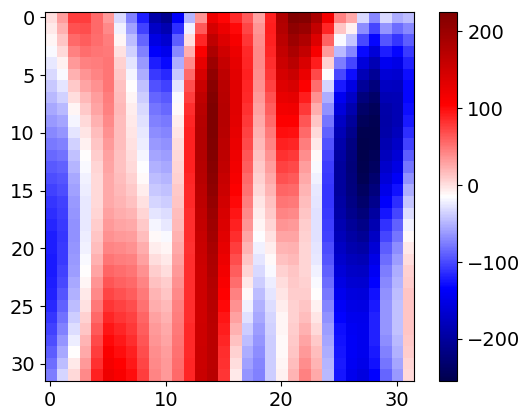

In [11]:
# Check the data visually 
(x, _), = validation_dataset.take(1)
plt.imshow(tf.squeeze(x), cmap = 'seismic')
plt.colorbar()
print(f"Data type: {x.dtype}")
print(f"Shape: {x.shape}")

## Train the model

In [12]:
trainer, history = train_das_model(
                    training_dataset,          # training dataset
                    validation_dataset,        # validation dataset
                    lmbda=2000,                # weight for rate–distortion Lagrangian
                    latent_dims=50,            # layers in latent space
                    patch_size = patch_size,   # patch size of the image, must be dividable by 4
                    epochs=100,                # epoch
                    batch_size=128,            # batch size
                    learning_rate=1e-3,        # learning rate
                    validation_freq=1,)        # validation freq
                    

Epoch 1/100
199/199 [==============================] - ETA: 0s - loss: 403.5985 - distortion_loss: 0.1458 - rate_loss: 111.9344 - distortion_pass_through_loss: 0.1458 - rate_pass_through_loss: 111.9355

199/199 [==============================] - 16s 17ms/step - loss: 403.5985 - distortion_loss: 0.1458 - rate_loss: 111.9344 - distortion_pass_through_loss: 0.1458 - rate_pass_through_loss: 111.9355 - val_loss: 330.1485 - val_distortion_loss: 0.1083 - val_rate_loss: 113.5297 - val_distortion_pass_through_loss: 0.1083 - val_rate_pass_through_loss: 113.5412
Epoch 2/100
199/199 [==============================] - 2s 9ms/step - loss: 313.2464 - distortion_loss: 0.1002 - rate_loss: 112.8987 - distortion_pass_through_loss: 0.1002 - rate_pass_through_loss: 112.8945 - val_loss: 305.4863 - val_distortion_loss: 0.0973 - val_rate_loss: 110.8870 - val_distortion_pass_through_loss: 0.0973 - val_rate_pass_through_loss: 110.8979
Epoch 3/100
199/199 [==============================] - 2s 12ms/step - loss: 296.0202 - distortion_loss: 0.0929 - rate_loss: 110.1456 - distortion_pass_through_loss: 0.0929 - rate_pass_through_loss: 110.1424 - val_loss: 292.3446 - val_distortion_loss: 0.0918 - val_rate_loss: 108.6

In [13]:
# show the analysis_transform model
trainer.analysis_transform.summary()

# show the model
trainer.synthesis_transform.summary()

Model: "analysis_transform"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 16, 16, 20)        520       
                                                                 
 conv_2 (Conv2D)             (None, 8, 8, 50)          25050     
                                                                 
 flatten (Flatten)           (None, 3200)              0         
                                                                 
 fc_1 (Dense)                (None, 500)               1600500   
                                                                 
 fc_2 (Dense)                (None, 50)                25050     
                                                                 
Total params: 1,651,120
Trainable params: 1,651,120
Non-trainable params: 0
_________________________________________________________________
Model: "synthesis_transform"
_________

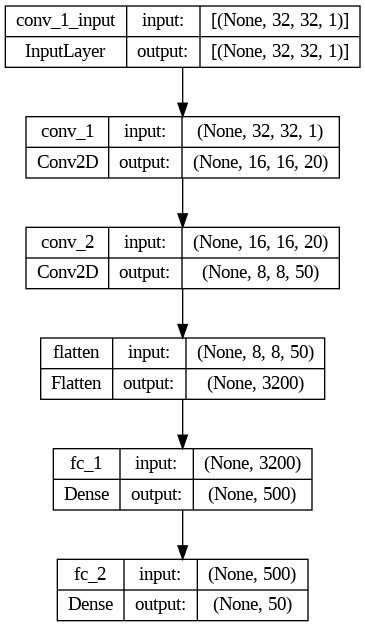

In [14]:
tf.keras.utils.plot_model(trainer.analysis_transform, to_file='model_analysis_transform.png', show_shapes=True)

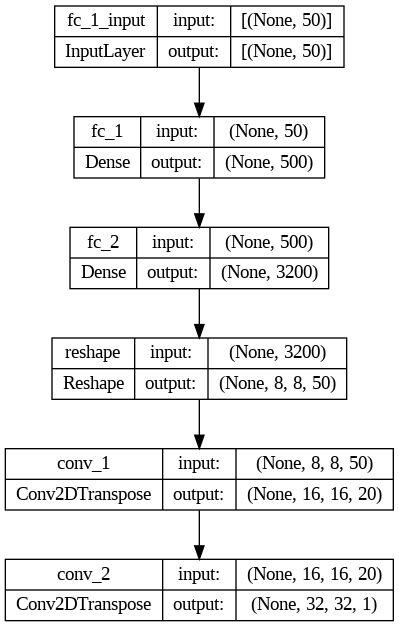

In [15]:
tf.keras.utils.plot_model(trainer.synthesis_transform, to_file='model_synthesis_transform.png', show_shapes=True)

In [16]:
# Save the model if we want
trainer.save_weights("das_compression_model_%d"%(patch_size))

In [17]:
history.history.keys()

dict_keys(['loss', 'distortion_loss', 'rate_loss', 'distortion_pass_through_loss', 'rate_pass_through_loss', 'val_loss', 'val_distortion_loss', 'val_rate_loss', 'val_distortion_pass_through_loss', 'val_rate_pass_through_loss'])

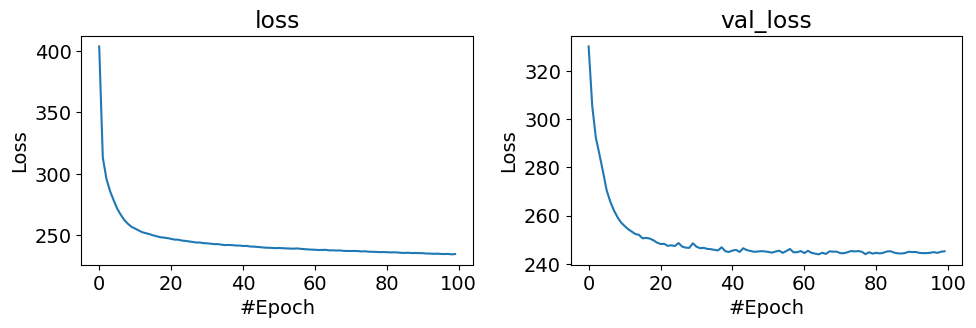

In [18]:
# loss_list = ['loss', 'val_loss', 'rate_loss', 'distortion_loss']

loss_list = ['loss', 'val_loss']

# Plot the rate_loss curve.
plt.figure(figsize=(10,6))
for i, l in enumerate(loss_list):
  plt.subplot(2, 2, i + 1)
  plt.plot(history.history[l])
  plt.xlabel('#Epoch')
  plt.ylabel('Loss')
  plt.title(l)

plt.tight_layout()
plt.savefig('Loss.png', dpi=300, pad_inches=0.1)
plt.show()

## Compress and Decompress on Validation dataset

For compression and decompression at test time, we split the trained model in two parts:

- The encoder side consists of the analysis transform and the entropy model.
- The decoder side consists of the synthesis transform and the same entropy model.

At test time, the latents will not have additive noise, but they will be quantized and then losslessly compressed, so we give them new names. We call them and the image reconstruction $\hat x$ and $\hat y$, respectively (following [End-to-end Optimized Image Compression](https://arxiv.org/abs/1611.01704)).

In [19]:
class DASCompressor(tf.keras.Model):
  """Compresses DAS data to strings."""

  def __init__(self, analysis_transform, entropy_model):
    super().__init__()
    self.analysis_transform = analysis_transform
    self.entropy_model = entropy_model

  def call(self, x):
    # Ensure inputs are floats in the range (0, 1).
    x = tf.cast(x, self.compute_dtype) / 255.
    y = self.analysis_transform(x)
    # Also return the exact information content of each digit.
    _, bits = self.entropy_model(y, training=False)
    return self.entropy_model.compress(y), bits


class DASDecompressor(tf.keras.Model):
  """Decompresses DAS data from strings."""

  def __init__(self, entropy_model, synthesis_transform):
    super().__init__()
    self.entropy_model = entropy_model
    self.synthesis_transform = synthesis_transform

  def call(self, string):
    y_hat = self.entropy_model.decompress(string, ())
    x_hat = self.synthesis_transform(y_hat)
    # Scale and cast back to 8-bit integer.
    return tf.saturate_cast(tf.round(x_hat * 255.), tf.float32)


When instantiated with `compression=True`, the entropy model converts the learned prior into tables for a range coding algorithm. When calling `compress()`, this algorithm is invoked to convert the latent space vector into bit sequences. The length of each binary string approximates the information content of the latent (the negative log likelihood of the latent under the prior).

The entropy model for compression and decompression must be the same instance, because the range coding tables need to be exactly identical on both sides. Otherwise, decoding errors can occur.

In [20]:
def make_das_codec(trainer, **kwargs):
  # The entropy model must be created with `compression=True` and the same
  # instance must be shared between compressor and decompressor.

  entropy_model = tfc.ContinuousBatchedEntropyModel(trainer.prior, coding_rank=1, compression=True, **kwargs)
  compressor = DASCompressor(trainer.analysis_transform, entropy_model)
  decompressor = DASDecompressor(entropy_model, trainer.synthesis_transform)
  
  return compressor, decompressor

In [21]:
# Setup the trained model 
compressor, decompressor = make_das_codec(trainer)

# Grab 16 images from the validation dataset. You can select a different subset by changing the argument to `skip`.
(originals, _), = validation_dataset.batch(128).skip(2).take(1)

# Compress them to strings, and keep track of each of their information content in bits.
strings, entropies = compressor(originals)

print(f"String representation of first digit in hexadecimal: 0x{strings[0].numpy().hex()}")
print(f"Number of bits actually needed to represent it: {entropies[0]:0.2f}")

# Decompress the images back from the strings.
reconstructions = decompressor(strings)


String representation of first digit in hexadecimal: 0x253a5b3be50a7acff07d43
Number of bits actually needed to represent it: 83.37


In [22]:
def get_memory_size(tf_array):

  # Convert the tensor to a NumPy array
  my_array = tf_array.numpy()

  # Get the memory size in bytes
  memory_size_mb = my_array.nbytes / (1024 * 1024)

  # Print the memory size
  print("Memory Size:", memory_size_mb, "MB")

  return memory_size_mb

origi_size_mb = get_memory_size(originals)
compr_size_mb = get_memory_size(strings)

print(origi_size_mb / compr_size_mb)

Memory Size: 0.5 MB
Memory Size: 0.0009765625 MB
512.0


In [23]:
def display_patch(originals, strings, entropies, reconstructions):
  """Visualizes 16 digits together with their reconstructions."""
  fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(12, 6))
  axes = axes.ravel()
  for i in range(len(axes)):
    image = tf.concat([   
        tf.squeeze(originals[i]),                                # original
        tf.zeros((originals[i].shape[1], 1), tf.float32) - 255,  # boundary 
        tf.squeeze(reconstructions[i]),                          # reconstruction
        tf.zeros((originals[i].shape[1], 1), tf.float32) - 255,  # boundary
        tf.squeeze(originals[i] - reconstructions[i])            # original - reconstruction
        ], 1)
    
    pclip = np.percentile(originals, 99.)
    axes[i].imshow(image, cmap='seismic', vmin=-pclip, vmax=pclip)

    txt = f"{entropies[i]:0.2f} bits"
    # axes[i].set_title(txt)
    # axes[i].axis("off")
    
  plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
  plt.tight_layout()
  plt.savefig('Patch.png', dpi=300, pad_inches=0.1)

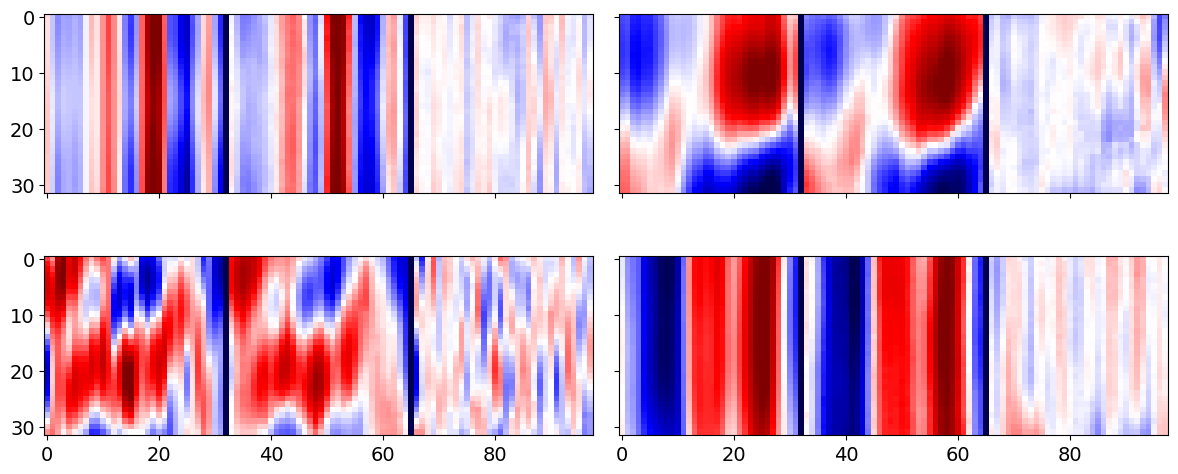

In [24]:
# 4 x 4 plots, for each: (original, reconstruction, original - reconstruction)
display_patch(originals, strings, entropies, reconstructions)

## Test the reconstruction for whole DAS section

In [25]:
# Load the original data just from one file
pdata = np.load(file_test[0])['pdata']
patches, factors = extract_image_patches(pdata, patch_size)
patches_original = tf.convert_to_tensor(patches, dtype=tf.float32)

In [26]:
# Compress them to strings, and keep track of each of their information content in bits.
strings, entropies = compressor(patches_original)

print(f"String representation of first digit in hexadecimal: 0x{strings[0].numpy().hex()}")
print(f"Number of bits actually needed to represent it: {entropies[0]:0.2f}")

# Decompress the images back from the strings.
patches_decompre = decompressor(strings)

String representation of first digit in hexadecimal: 0xf934b9a81bf07a3df95f178f
Number of bits actually needed to represent it: 91.33


In [27]:
# Compare the size in Mb
origi_size_mb = get_memory_size(patches_original)
compr_size_mb = get_memory_size(strings)
decompr_size_mb = get_memory_size(patches_decompre)

print(origi_size_mb / compr_size_mb)

Memory Size: 54.4921875 MB
Memory Size: 0.1064300537109375 MB
Memory Size: 54.4921875 MB
512.0


In [28]:
# Load the original data just from one file
# Warning: this data has been used in training!! 
# We need to benchmark other data not used in training later.
original_shape = pdata.shape
print('shape of original data: ', original_shape)

original_das = reconstruct_image_from_patches(patches_original, factors, original_shape, patch_size)
decompre_das = reconstruct_image_from_patches(patches_decompre, factors, original_shape, patch_size)

shape of original data:  (4800, 3000)


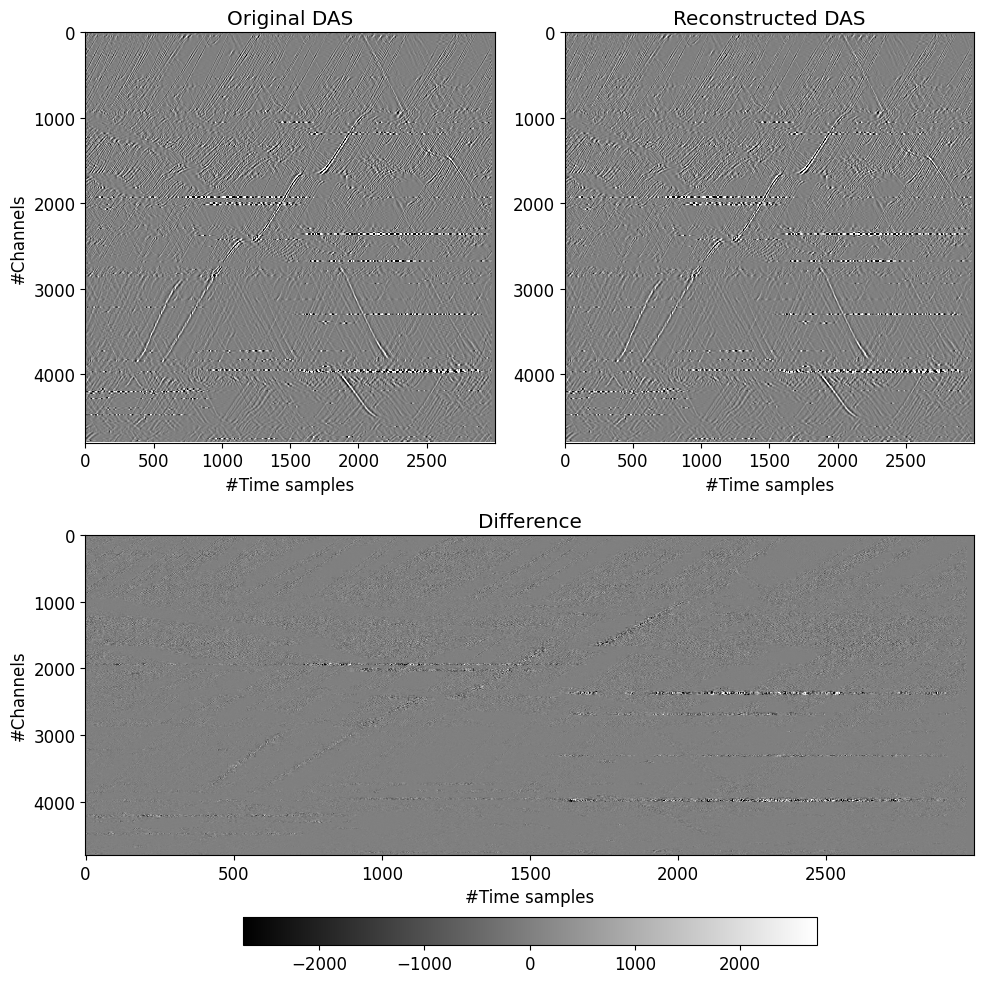

In [48]:
plt.figure(figsize=(10, 10))
plt.rcParams.update({'font.size': 12})

plt.subplot(212)
pclip = np.percentile(original_das, 98.5)
plt.imshow(original_das - decompre_das, cmap='gray', aspect='auto', vmin=-pclip, vmax=pclip)
plt.xlabel('#Time samples')
plt.ylabel('#Channels')
plt.title('Difference')
plt.colorbar(orientation="horizontal",fraction=0.07)

plt.subplot(221)
plt.imshow(original_das, cmap='gray', aspect='auto', vmin=-pclip, vmax=pclip)
plt.xlabel('#Time samples')
plt.ylabel('#Channels')
plt.title('Original DAS')
# plt.colorbar(orientation="horizontal",fraction=0.07)

plt.subplot(222)
plt.imshow(decompre_das, cmap='gray', aspect='auto', vmin=-pclip, vmax=pclip)
plt.xlabel('#Time samples')
# plt.ylabel('#Channels')
plt.title('Reconstructed DAS')
# plt.colorbar(orientation="horizontal",fraction=0.07)

plt.tight_layout()
plt.savefig('Final-DAS.png', dpi=300, pad_inches=0.1)